# Анализ и фильтрация злонамеренного сетевого трафика

Компания онлайн-сервис с высоким уровнем входящего трафика имеет специализированный отдел безопасности, который занимается фильтрацией и анализом трафика. Сотрудники этого отдела обратились за помощью в автоматизации выявления аномального и злонамеренного трафика.

**Цель:** Разработать модель, которая будет классифицировать трафик на нормальный и злонамеренный, включая следующие типы атак: DDoS, SQL-инъекции, брутфорс, вредоносные программы и т.д.

**Цель исследования:** Разработка модели, которая достигнет наилучшего значения по различным метрикам классификации: `precision`, `recall`, `f1_score`, `accuracy`.

**Задачи:**
- загрузить и ознакомится с данными,
- провести предварительную обработку,
- сделать полноценный разведочный анализ,
- проверить на мультиколлинеарность,
- сделать отбор финального набора обучающих признаков,
- выбрать и обучить модели,
- провести итоговую оценку качества предсказания лучшей модели,
- сделать анализ важности признаков модели.

**Входные данные.** Файл в формате `.csv` с различными параметрами входящего трафика (`~540000` строк)

**Формальная задача.** Предсказать значение `label` для входящего трафика по заданным параметрам

**Ожидаемый результат.** Построена модель для детектирования вредоносного трафика, с наилучшим значением метрик классификации: `precision`, `recall`, `f1_score`, `accuracy`.

# Содержание

**[1.Импорт библиотек](#1)**

**[2. Обзор и предобработка данных](#2)**

**[3. Моделирование](#3)**

- **[3.1. Подготовка данных к моделированию.](#3.1)**
- **[3.2. Обучение моделей](#3.2)**


**[4. Тестирование лучшей модели](#4)**

**[5. Оценка важности признаков](#5)**

**[6. Сохрание модели для создания REST API сервиса с использованием Flask и Docker](#6)**

**[7. Итоговый вывод](#7)**


# 1. Импорт библиотек.

In [1]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.3 MB/s eta 0:00:00


In [2]:
# импорты из стандартной библиотеки
import warnings

# импорты сторонних библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# импорты модулей текущего проекта
# длина строки до 78 символов
from catboost import CatBoostClassifier, Pool
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


from sklearn.model_selection import (
    GridSearchCV,
    train_test_split
)

from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    StandardScaler,
    LabelEncoder
)

from sklearn import metrics
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    precision_recall_curve,
    recall_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report
)

# настройки
np.warnings = warnings
warnings.filterwarnings("ignore")

# константы заглавными буквами
RANDOM_STATE = 42

# 2. Обзор и предобработка данных.

Датасет хранится на google-диске по ссылке:

 https://drive.google.com/file/d/1_um1uc1_qBFNG5EbweSM61kvgRzYyPPI/view?usp=drive_link

 Загрузим данные

In [3]:
!gdown --id 1_um1uc1_qBFNG5EbweSM61kvgRzYyPPI

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1_um1uc1_qBFNG5EbweSM61kvgRzYyPPI
To: /content/network_traffic_data.csv
100% 172M/172M [00:01<00:00, 108MB/s]


In [4]:
df = pd.read_csv('/content/network_traffic_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539616 entries, 0 to 539615
Data columns (total 79 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0    Destination Port             539616 non-null  int64  
 1    Flow Duration                539616 non-null  int64  
 2    Total Fwd Packets            539616 non-null  int64  
 3    Total Backward Packets       539616 non-null  int64  
 4   Total Length of Fwd Packets   539616 non-null  int64  
 5    Total Length of Bwd Packets  539616 non-null  int64  
 6    Fwd Packet Length Max        539616 non-null  int64  
 7    Fwd Packet Length Min        539616 non-null  int64  
 8    Fwd Packet Length Mean       539616 non-null  float64
 9    Fwd Packet Length Std        539616 non-null  float64
 10  Bwd Packet Length Max         539616 non-null  int64  
 11   Bwd Packet Length Min        539616 non-null  int64  
 12   Bwd Packet Length Mean       539616 non-nul

In [5]:
df.sample()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
312211,80,4,2,0,0,0,0,0,0.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,DoS Hulk


- Имеем датасет, в котором 539616 строчек и 79 столбцов
- Целевая переменная `Label` - категориальная. Все остальные данные - числовые.
- Названия признаков имеют лишние пробелы

In [6]:
# Приведем названия столбцов к змеиному регистру, уберем лишние пробелы

#Приведем названия колонок к стандарту
df.columns = df.columns.str.replace(' ', '')
df.columns = (df.columns.str.replace('(?<=[a-z])(?=[A-Z])', '_', regex=True).str.lower())
df.columns

Index(['destination_port', 'flow_duration', 'total_fwd_packets',
       'total_backward_packets', 'total_lengthof_fwd_packets',
       'total_lengthof_bwd_packets', 'fwd_packet_length_max',
       'fwd_packet_length_min', 'fwd_packet_length_mean',
       'fwd_packet_length_std', 'bwd_packet_length_max',
       'bwd_packet_length_min', 'bwd_packet_length_mean',
       'bwd_packet_length_std', 'flow_bytes/s', 'flow_packets/s',
       'flow_iatmean', 'flow_iatstd', 'flow_iatmax', 'flow_iatmin',
       'fwd_iattotal', 'fwd_iatmean', 'fwd_iatstd', 'fwd_iatmax', 'fwd_iatmin',
       'bwd_iattotal', 'bwd_iatmean', 'bwd_iatstd', 'bwd_iatmax', 'bwd_iatmin',
       'fwd_pshflags', 'bwd_pshflags', 'fwd_urgflags', 'bwd_urgflags',
       'fwd_header_length', 'bwd_header_length', 'fwd_packets/s',
       'bwd_packets/s', 'min_packet_length', 'max_packet_length',
       'packet_length_mean', 'packet_length_std', 'packet_length_variance',
       'finflag_count', 'synflag_count', 'rstflag_count', 'pshfl

In [7]:
# Посмотрим на описание данных
df.describe().T.style.set_caption('Таблица числового описания датасета')

,count,mean,std,min,25%,50%,75%,max
destination_port,539616.000000,5563.061394,14921.262751,0.000000,80.000000,80.000000,443.000000,65533.000000
flow_duration,539616.000000,21066929.368501,38121719.627258,-12.000000,73.000000,49739.000000,10640295.250000,119999993.000000
total_fwd_packets,539616.000000,6.119972,345.109317,1.000000,1.000000,2.000000,6.000000,200755.000000
total_backward_packets,539616.000000,5.985495,463.490949,0.000000,1.000000,2.000000,5.000000,270686.000000
total_lengthof_fwd_packets,539616.000000,408.237107,7478.350579,0.000000,2.000000,44.000000,320.000000,2866110.000000
total_lengthof_bwd_packets,539616.000000,7999.779419,1014441.804219,0.000000,0.000000,105.000000,8216.250000,591000000.000000
fwd_packet_length_max,539616.000000,169.449966,560.533869,0.000000,2.000000,23.000000,272.000000,24820.000000
fwd_packet_length_min,539616.000000,11.855382,60.961661,0.000000,0.000000,0.000000,6.000000,2065.000000
fwd_packet_length_mean,539616.000000,44.681011,150.873880,0.000000,2.000000,11.220000,48.560000,5940.000000
fwd_packet_length_std,539616.000000,59.525095,217.729412,0.000000,0.000000,0.000000,91.700000,7050.000000


Из таблицы числового описания датасета видно, что датасет содержит:

- бесконечные значения inf (столбцы flow_bytes/s и flow_packets/s);
- столбцы с полностью нулевыми значениями;
- пропуски.

In [8]:
# Составим список стобцов, в которых все значения = 0

nul_columns_list = []

for col in df.columns[:-1]:
  if df[col].mean() == 0:
    nul_columns_list.append(str(col))
  else:
    continue

print('Список столбцов, все значения которых - нули:' "\n", nul_columns_list)

Список столбцов, все значения которых - нули:
 ['bwd_pshflags', 'bwd_urgflags', 'fwd_avg_bytes/bulk', 'fwd_avg_packets/bulk', 'fwd_avg_bulk_rate', 'bwd_avg_bytes/bulk', 'bwd_avg_packets/bulk', 'bwd_avg_bulk_rate']


In [9]:
# Посмотрим на значения в целевом признаке

df['label'].unique()

array(['BENIGN', 'PortScan', 'DoS Hulk', 'DDoS', 'Bot', 'Infiltration',
       'Web Attack � Brute Force', 'Web Attack � XSS',
       'Web Attack � Sql Injection', 'FTP-Patator', 'SSH-Patator',
       'DoS slowloris', 'DoS Slowhttptest', 'DoS GoldenEye', 'Heartbleed'],
      dtype=object)

In [10]:
df['label'].nunique()

15

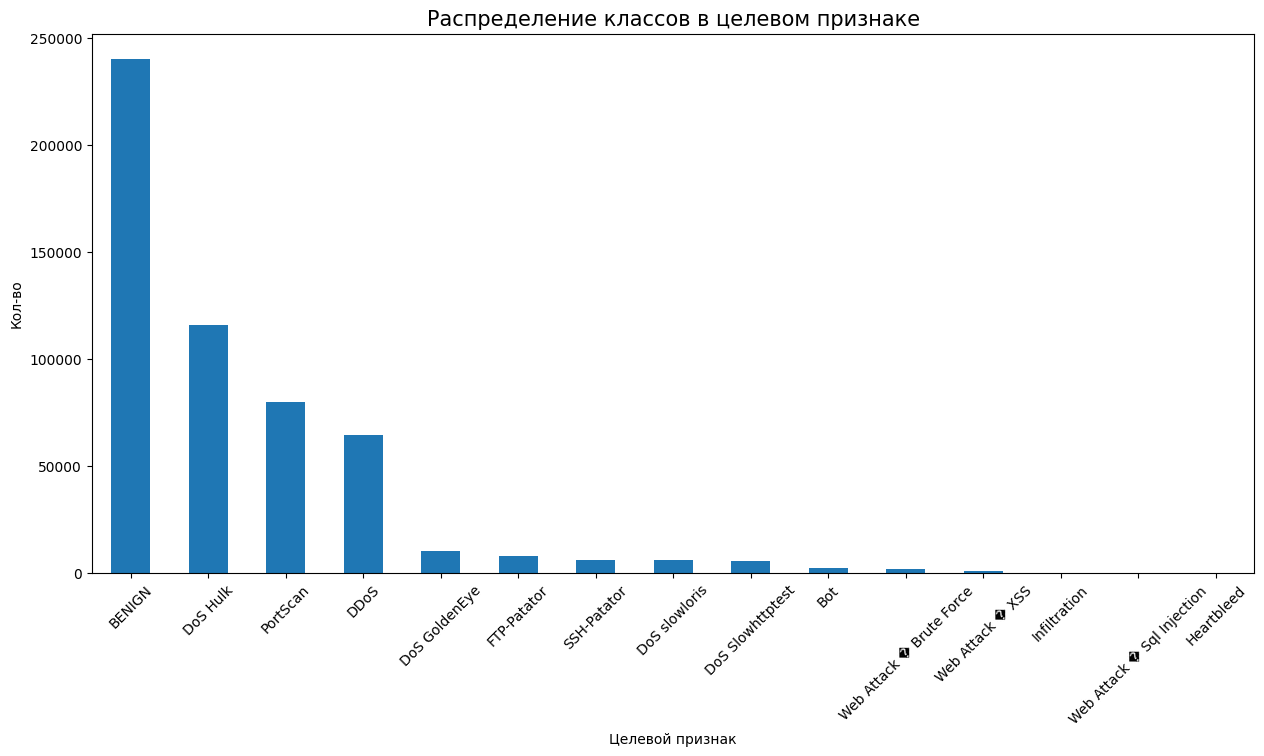

In [11]:
# Посмотрим на распределение классов в целевом признаке

plt.figure(figsize=(15, 7))
df['label'].value_counts().plot.bar()
plt.xticks(rotation=45)
plt.title('Распределение классов в целевом признаке', fontsize=15)
plt.xlabel('Целевой признак')
plt.ylabel('Кол-во')

plt.show()

Мы имеем 15 уникальных классов целевого признака. На графике хорошо видно, что классы в целевом признаке распределены крайне неравномерно.

In [12]:
# Проверим столбцы на наличие пропусков
for col in df:
    if df[col].isna().sum()>0:
        print('Кол-во пропусков в столбце', col, '=', df[col].isna().sum())

Кол-во пропусков в столбце flow_bytes/s = 488


In [13]:
# Заменим пропуски в столбце flow_bytes/s на медианные значения по столбцу
df['flow_bytes/s'].fillna(df['flow_bytes/s'].median(), inplace=True)

# И снова проверим столбец на пропуски
print('Количество пропусков в столбце flow_bytes/s после заполнения =', df['flow_bytes/s'].isna().sum())

Количество пропусков в столбце flow_bytes/s после заполнения = 0


In [14]:
# Помимо пропусков в данных есть бесконечные значения inf.

infinite_values = df.replace([np.inf, -np.inf], np.nan).isna().sum()

# Выводим названия столбцов и количество бесконечных значений
for column, count in infinite_values.items():
    if count > 0:
        print(f"Столбец {column} содержит {count} бесконечных значений.")

Столбец flow_bytes/s содержит 246 бесконечных значений.
Столбец flow_packets/s содержит 734 бесконечных значений.


In [15]:
# Заменим бесконечности на пропуски
df = df.replace([np.inf, -np.inf], np.nan)

In [16]:
# Заполняем пропуски в столбцах flow_bytes/s и flow_packets/s максимальным значением по каждому столбцу

df['flow_bytes/s'].fillna(df['flow_bytes/s'].max(), inplace=True)
df['flow_packets/s'].fillna(df['flow_packets/s'].max(), inplace=True)

# И снова проверяем столбцы на пропуски
print('Количество пропусков в столбце flow_bytes/s после заполнения =', df['flow_bytes/s'].isna().sum())
print('Количество пропусков в столбце flow_packets/s после заполнения =', df['flow_packets/s'].isna().sum())

Количество пропусков в столбце flow_bytes/s после заполнения = 0
Количество пропусков в столбце flow_packets/s после заполнения = 0


In [17]:
# Проверим данные на наличие дубликатов
print('Количество явных дубликатов в датасете:', df.duplicated().sum())

Количество явных дубликатов в датасете: 64601


In [18]:
# Удаляем дубликаты
df = df.drop_duplicates().reset_index(drop=True)

# И снова проверяем на наличие дублей
print('Количество явных дубликатов в датасете:', df.duplicated().sum())

Количество явных дубликатов в датасете: 0


In [19]:
# Проверим корреляцию числовых признаков между собой
df.corr().style.background_gradient(axis=None, cmap='YlOrRd')

В данных есть сильно коррелирующие признаки - эта особенность может негативно отразиться на качестве предсказания линейной модели.

**ВЫВОД**:

В рамках предобработки данных были проведены следующие действия:

- названия столбцов приведены к змеиному регистру,
- пропуски заполнены медианными значениями по столбцу,
- бесконечные значения заполнены максимальными значениями по столбцу,
- обнаружены признаки, все значения которых = 0,
- удалены дубликаты,
- данные исследованы на мультиколлинеарность,
- при исследовании распределения классов в целевом столбце, выявлен сильный дисбаланс.


# 3. Моделирование.

После предобработки данных перейдём к обучению моделей. Сперва разделим выборки на обучающую и тестовую, а потом обучим на тренировочных данных 3 модели:
- градиентный бустинг,
- логистическую регрессию,
- случайный лес.

Далее, выберем лучшую модель, исследуем значимость признаков, и попробуем еще улучшить ее, удалив признаки с крайне низкой значимостью. Если эксперимент с удалением признаков окажется удачным - именно эту модель будем проверять на тестовой выборке. Если удаление признаков никак не улучшит качесво предсказания - вернемся к предыдущей версии лучшей модели, с полным набором признаков.

Для оценки качества моделей будем использовать метрики `precision`, `recall`, `f1_score`, `accuracy`.

Перед нами задача мультиклассовой классификации, в классах имеется сильный дисбаланс. Поэтому целесообразно использовать для оценки микро- или макро-усреднение (micro-averaging и macro-averaging): они позволяют объединить показатели производительности по отдельным классам для получения общей оценки модели.

Микро-усреднение учитывает каждый экземпляр отдельно, тогда как макро-усреднение учитывает каждый класс одинаково.

Нам важно, чтобы даже самый малочисленный класс определялся с высокой точностью, поэтому возьмем метрику F1-мера в варианте `macro` - он считает F1-меру для каждой класса, а затем считает среднее значение. Из-за этого даже самый малый класс имеет одинаковый вес при расчёте средней метрики.

## 3.1. Подготовка данных к моделированию.

In [20]:
# Делим признаки на фичи и таргет:
X = df.drop('label', axis=1)
y = df['label']

In [21]:
# Разбиваем на выборки - обучающую и тестовую:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

In [23]:
# Выделяем из train валидационную выборку

# Но сначала создадим полную обучающую выборку, в которой объединены train и val
train_full_X = X_train
train_full_y = y_train


# Выделим валидационную выборку:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=RANDOM_STATE, stratify=y_train)

# Проверим размеры сетов
print('Изначальный датафрейм после предобработки:', df.shape)
print('X_train:', X_train.shape)
print('X_valid:', X_valid.shape)
print('X_test:', X_test.shape)
print('Полный обучающий сет train_full_X:', train_full_X.shape)

Изначальный датафрейм после предобработки: (475015, 79)
X_train: (285009, 78)
X_valid: (95003, 78)
X_test: (95003, 78)
Полный обучающий сет train_full_X: (380012, 78)


## 3.2. Обучение моделей.

Начнем с градиентного бустинга. Будем использовать его в реализации CatBoostClassifier(). В этой модели отлично настроены дефолтные параметры, что позволяет получить достаточно хорошее качество предсказания "из коробки". Поэтому подбор гиперпараметров делать не будем.

Масштабирование признаков и удаление коррелирующих признаков нам делать также не придется, поскольку модель CatBoostClassifier() не чувствительна к этим особенностям данных.

Таким образом, подавать будем сырые данные, без какой-либо предобработки.


### **Модель градиентного бустинга в реализации CatBoost**

In [24]:
# Создадим пулы данных

train_data = Pool(data=X_train,
                  label=y_train
                 )

valid_data = Pool(data=X_valid,
                  label=y_valid
                 )

test_data = Pool(data=X_test,
                label=y_test
                )


train_full_data = Pool(data = train_full_X,
                       label = train_full_y
                      )

In [25]:
# Прописываем параметры модели

params = {'verbose': 100,
         'random_seed': 42,
         'learning_rate': 0.01,
         'iterations': 5000,
         'loss_function' : 'MultiClass',
         'early_stopping_rounds': 4500,
         'eval_metric': 'Accuracy',
         #'eval_metric': 'F1',
         'custom_metric': ['Accuracy','F1', 'Precision', 'Recall'],
         'task_type': "GPU",
         'devices':'0:1',
         'save_snapshot': False
         }

model_cb = CatBoostClassifier(**params)

In [26]:
%%time

model_cb.fit(train_data, eval_set=valid_data)

0:	learn: 0.9340231	test: 0.9338652	best: 0.9338652 (0)	total: 113ms	remaining: 9m 24s
100:	learn: 0.9698010	test: 0.9699483	best: 0.9700009 (92)	total: 6.54s	remaining: 5m 17s
200:	learn: 0.9781375	test: 0.9781270	best: 0.9781270 (200)	total: 15.1s	remaining: 6m
300:	learn: 0.9863022	test: 0.9858741	best: 0.9858741 (300)	total: 21.1s	remaining: 5m 29s
400:	learn: 0.9885197	test: 0.9883477	best: 0.9883688 (399)	total: 29.5s	remaining: 5m 38s
500:	learn: 0.9912143	test: 0.9910003	best: 0.9910003 (500)	total: 37.9s	remaining: 5m 40s
600:	learn: 0.9928634	test: 0.9928002	best: 0.9928002 (595)	total: 43.8s	remaining: 5m 20s
700:	learn: 0.9935686	test: 0.9936213	best: 0.9936634 (694)	total: 52.2s	remaining: 5m 19s
800:	learn: 0.9942528	test: 0.9942528	best: 0.9942633 (797)	total: 58.1s	remaining: 5m 4s
900:	learn: 0.9957650	test: 0.9958422	best: 0.9958738 (895)	total: 1m 6s	remaining: 5m 1s
1000:	learn: 0.9959791	test: 0.9960422	best: 0.9960528 (993)	total: 1m 13s	remaining: 4m 53s
1100:	le

In [27]:
# Определяем итерацию, на которой модель достигла наилучшего результата
model_cb.best_iteration_

4991

In [29]:
# Создадим отчет с результатами модели по каждому классу
classification = metrics.classification_report(y_valid, model_cb.predict(X_valid), zero_division = 0)
print("Отчет для модели CatBoostClassifier, валидационная выборка:", "\n", classification)

Отчет для модели CatBoostClassifier, валидационная выборка: 
                             precision    recall  f1-score   support

                    BENIGN       1.00      1.00      1.00     46562
                       Bot       0.96      0.98      0.97       391
                      DDoS       1.00      1.00      1.00     12873
             DoS GoldenEye       1.00      0.99      1.00      2057
                  DoS Hulk       1.00      1.00      1.00     17450
          DoS Slowhttptest       1.00      0.99      0.99      1045
             DoS slowloris       0.99      0.99      0.99      1077
               FTP-Patator       1.00      1.00      1.00      1187
                Heartbleed       1.00      1.00      1.00         2
              Infiltration       1.00      0.43      0.60         7
                  PortScan       1.00      1.00      1.00     11280
               SSH-Patator       1.00      1.00      1.00       644
  Web Attack � Brute Force       0.73      0.93      

In [30]:
# Выводим основные метрики для результирующей таблицы
f1_macro_cb_val = metrics.f1_score(y_valid, model_cb.predict(X_valid), average='macro')
accu_cb_val = accuracy_score(y_valid, model_cb.predict(X_valid))
precision_cb_val = precision_score(y_valid, model_cb.predict(X_valid), average='macro')
recall_cb_val = recall_score(y_valid, model_cb.predict(X_valid), average='macro')

print('Метрики для модели CatBoostClassifier на валидационной выборке')
print('F1-macro:', f1_macro_cb_val.round(4))
print('Accuracy:', accu_cb_val.round(4))
print('Precision:', precision_cb_val.round(4))
print('Recall:', recall_cb_val.round(4))

Метрики для модели CatBoostClassifier на валидационной выборке
F1-macro: 0.8723
Accuracy: 0.9975
Precision: 0.9522
Recall: 0.8518


### **Логистическая регрессия**

В отличие от бустинговых, линейные модели очень чувствительны к мультиколлинеарности, поэтому качество предсказания для этой модели может оказаться значительно хуже. Проверим это предположение.

In [31]:
%%time

# Создаем пайплайн для логистической регрессии с предварительным масштабированием данных
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=RANDOM_STATE))
])

# Определяем сетку гиперпараметров для логистической регрессии
param_lr = {
    'classifier__C': [0.01, 1, 10],
    'classifier__penalty': ['l1', 'l2']
}

# Инициализируем GridSearchCV с пайплайном и сеткой гиперпараметров
model_lr = GridSearchCV(pipeline_lr, param_lr, cv=3, scoring='f1_macro', n_jobs=-1)

# Обучаем модель с кросс-валидацией на полных данных
model_lr.fit(train_full_X, train_full_y)

# Выводим лучшие найденные параметры и оценку F1-меры
print("Лучшие параметры:", model_lr.best_params_)
print("Значение метрики F1-macro для модели LogisticRegression, валидационная выборка:", model_lr.best_score_)

Лучшие параметры: {'classifier__C': 10, 'classifier__penalty': 'l2'}
Значение метрики F1-macro для модели LogisticRegression, валидационная выборка: 0.6485101107646015
CPU times: user 57.9 s, sys: 19 s, total: 1min 16s
Wall time: 4min 21s


In [32]:
classification = metrics.classification_report(y_valid, model_lr.predict(X_valid), zero_division = 0) #target_names=target_names,
print("Отчет для модели LogisticRegression, валидационная выборка:", "\n", classification)

Отчет для модели LogisticRegression, валидационная выборка: 
                             precision    recall  f1-score   support

                    BENIGN       0.98      0.96      0.97     46562
                       Bot       0.64      0.02      0.04       391
                      DDoS       0.99      1.00      0.99     12873
             DoS GoldenEye       0.97      0.89      0.93      2057
                  DoS Hulk       0.95      1.00      0.97     17450
          DoS Slowhttptest       0.94      0.91      0.92      1045
             DoS slowloris       0.90      0.91      0.91      1077
               FTP-Patator       0.88      0.99      0.94      1187
                Heartbleed       1.00      1.00      1.00         2
              Infiltration       0.33      0.14      0.20         7
                  PortScan       0.93      0.99      0.96     11280
               SSH-Patator       0.98      0.93      0.95       644
  Web Attack � Brute Force       0.57      0.04      

In [33]:
# Выводим основные метрики
f1_macro_lr_val = metrics.f1_score(y_valid, model_lr.predict(X_valid), average='macro')
accu_lr_val = accuracy_score(y_valid, model_lr.predict(X_valid))
precision_lr_val = precision_score(y_valid, model_lr.predict(X_valid), average='macro')
recall_lr_val = recall_score(y_valid, model_lr.predict(X_valid), average='macro')

print('Метрики для модели LogisticRegression на валидационной выборке')
print('F1-macro:', f1_macro_lr_val.round(4))
print('Accuracy:', accu_lr_val.round(4))
print('Precision:', precision_lr_val.round(4))
print('Recall:', recall_lr_val.round(4))

Метрики для модели LogisticRegression на валидационной выборке
F1-macro: 0.6577
Accuracy: 0.9639
Precision: 0.7384
Recall: 0.6523


### **Случайный лес**

In [34]:
%%time

# Создаем пайплайн для случайного леса с предварительным масштабированием данных
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=RANDOM_STATE))
])

# Определяем сетку гиперпараметров для случайного леса
param_rf = {
    'classifier__n_estimators': range(50, 151, 50),
    'classifier__max_depth': range(8, 10),
    #'classifier__min_samples_split': (2, 3),
    #'classifier__min_samples_leaf': (2, 3),
    'classifier__bootstrap': [True, False],
    'classifier__criterion': ['gini', 'entropy']
}

# Инициализируем GridSearchCV с пайплайном и сеткой гиперпараметров
model_rf = GridSearchCV(pipeline_rf, param_rf, cv=3, scoring='f1_macro', verbose=10, n_jobs=-1)

# Обучаем модель с кросс-валидацией на полных данных
model_rf.fit(train_full_X, train_full_y)

# Выводим лучшие найденные параметры и оценку F1-меры
print("Лучшие параметры:", model_rf.best_params_)
print("Значение метрики F1-macro для модели RandomForestClassifier, валидационная выборка:", model_rf.best_score_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Лучшие параметры: {'classifier__bootstrap': False, 'classifier__criterion': 'entropy', 'classifier__max_depth': 9, 'classifier__n_estimators': 150}
Значение метрики F1-macro для модели RandomForestClassifier, валидационная выборка: 0.7863996084860849
CPU times: user 4min, sys: 7.64 s, total: 4min 7s
Wall time: 1h 13min 30s


In [35]:
classification = metrics.classification_report(y_valid, model_rf.predict(X_valid), zero_division = 0) #target_names=target_names,
print("Отчет для модели RandomForestClassifier, валидационная выборка:", "\n", classification)

Отчет для модели RandomForestClassifier, валидационная выборка: 
                             precision    recall  f1-score   support

                    BENIGN       0.99      1.00      0.99     46562
                       Bot       0.95      0.62      0.75       391
                      DDoS       1.00      1.00      1.00     12873
             DoS GoldenEye       1.00      0.99      0.99      2057
                  DoS Hulk       1.00      0.99      0.99     17450
          DoS Slowhttptest       1.00      0.99      0.99      1045
             DoS slowloris       1.00      0.99      0.99      1077
               FTP-Patator       1.00      1.00      1.00      1187
                Heartbleed       1.00      1.00      1.00         2
              Infiltration       1.00      0.14      0.25         7
                  PortScan       1.00      1.00      1.00     11280
               SSH-Patator       1.00      0.93      0.96       644
  Web Attack � Brute Force       0.68      0.83  

In [36]:
# Выводим основные метрики
f1_macro_rf_val = metrics.f1_score(y_valid, model_rf.predict(X_valid), average='macro')
accu_rf_val = accuracy_score(y_valid, model_rf.predict(X_valid))
precision_rf_val = precision_score(y_valid, model_rf.predict(X_valid), average='macro')
recall_rf_val = recall_score(y_valid, model_rf.predict(X_valid), average='macro')

print('Метрики для модели LogisticRegression на валидационной выборке')
print('F1-macro:', f1_macro_rf_val.round(4))
print('Accuracy:', accu_rf_val.round(4))
print('Precision:', precision_rf_val.round(4))
print('Recall:', recall_rf_val.round(4))

Метрики для модели LogisticRegression на валидационной выборке
F1-macro: 0.7828
Accuracy: 0.9923
Precision: 0.907
Recall: 0.7666


Для трех обученных моделей сравним значения метрик, полученных на валидационной выборке.

In [37]:
# Подготовим результирующую таблицу

results = pd.DataFrame({'Learning model':['CatBoostClassifier', 'LogisticRegression', 'RandomForestClassifier'],
                        'F1-score':[f1_macro_cb_val, f1_macro_lr_val, f1_macro_rf_val],
                        'Accuracy':[accu_cb_val, accu_lr_val, accu_rf_val],
                        'Precision':[precision_cb_val, precision_lr_val, precision_rf_val],
                        'Recall':[recall_cb_val, recall_lr_val, recall_rf_val]})

results

,Learning model,F1-score,Accuracy,Precision,Recall
0,CatBoostClassifier,0.872334,0.997505,0.952216,0.851805
1,LogisticRegression,0.657701,0.963927,0.738378,0.652311
2,RandomForestClassifier,0.782804,0.992274,0.907036,0.766645


Хотя все модели показали относительно высокую точность (Accuracy у всех выше 0.96), по остальным метрикам с большим отрывом побеждат модель CatBoostClassifier. Дальше будем работать только с этой моделью: попробуем улучшить качество ее предсказания, удалив признаки с крайне низкой значимостью.

Исследуем важность признаков

In [38]:
model_cb.get_feature_importance(prettified=True)

,Feature Id,Importances
0,destination_port,11.527477
1,init_win_bytes_forward,7.189178
2,fwd_packet_length_max,5.949879
3,init_win_bytes_backward,5.834692
4,bwd_packet_length_std,5.555447
...,...,...
73,fwd_avg_packets/bulk,0.000000
74,fwd_avg_bulk_rate,0.000000
75,bwd_avg_bytes/bulk,0.000000
76,bwd_avg_packets/bulk,0.000000


In [39]:
model_cb.get_feature_importance(prettified=True).sort_values(by='Importances').head(10)

,Feature Id,Importances
77,bwd_avg_bulk_rate,0.0
67,bwd_pshflags,0.0
68,bwd_urgflags,0.0
69,synflag_count,0.0
70,rstflag_count,0.0
76,bwd_avg_packets/bulk,0.0
72,fwd_avg_bytes/bulk,0.0
73,fwd_avg_packets/bulk,0.0
74,fwd_avg_bulk_rate,0.0
75,bwd_avg_bytes/bulk,0.0


Ранее мы уже составляли список столбцов, состоящих полностью из нулей - nul_columns_list. В рейтинге важности признаков среди прочих присутствуют признаки из этого списка, и с высокой вероятностью удаление именно этого набора признаков как минимум не ухудшит качество предсказания модели. 

Удаление других признаков с низким рейтингом значимости может привести к ухудшению качества предсказания, поскольку в этих признаках присутствуют информативные значения. В рамках данного проекта мы не будем проводить эксперимент с последовательным удалением каждого незначительного признака (и их разных комбинаций) и сравнением полученных результатов, поскольку это потребует много времени и ресурсов. 

Ограничимся удалением набора признаков из списка nul_columns_list.

In [40]:
nul_columns_list

['bwd_pshflags',
 'bwd_urgflags',
 'fwd_avg_bytes/bulk',
 'fwd_avg_packets/bulk',
 'fwd_avg_bulk_rate',
 'bwd_avg_bytes/bulk',
 'bwd_avg_packets/bulk',
 'bwd_avg_bulk_rate']

Удалим неважные признаки и посмотрим, улучшит ли это качество модели

In [41]:
# Определяем новую выборку для обучения модели на урезенной выборке признаков
X_new = X.copy()
X_new.shape

(475015, 78)

In [42]:
X_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 475015 entries, 0 to 475014
Data columns (total 78 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   destination_port            475015 non-null  int64  
 1   flow_duration               475015 non-null  int64  
 2   total_fwd_packets           475015 non-null  int64  
 3   total_backward_packets      475015 non-null  int64  
 4   total_lengthof_fwd_packets  475015 non-null  int64  
 5   total_lengthof_bwd_packets  475015 non-null  int64  
 6   fwd_packet_length_max       475015 non-null  int64  
 7   fwd_packet_length_min       475015 non-null  int64  
 8   fwd_packet_length_mean      475015 non-null  float64
 9   fwd_packet_length_std       475015 non-null  float64
 10  bwd_packet_length_max       475015 non-null  int64  
 11  bwd_packet_length_min       475015 non-null  int64  
 12  bwd_packet_length_mean      475015 non-null  float64
 13  bwd_packet_len

In [43]:
# Удаляем из ранее определенной выборки лишние признаки:
X_new = X_new.drop(nul_columns_list, axis=1)
X_new.shape

(475015, 70)

In [44]:
y.shape

(475015,)

In [45]:
# Разбиваем на выборки - обучающую и тестовую:
X_new_train, X_new_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

# Зафиксируем полную обучающую выборку, в которой объединены train и val
train_full_X_new = X_new_train.copy()

# Выделим валидационную выборку:
X_new_train, X_new_valid, y_train, y_valid = train_test_split(X_new_train, y_train, test_size=0.25, random_state=RANDOM_STATE, stratify=y_train)

# Проверим размеры сетов
print('Изначальный датафрейм после предобработки:', df.shape)
print('X_new_train:', X_new_train.shape)
print('X_new_valid:', X_new_valid.shape)
print('X_new_test:', X_new_test.shape)
print('Полный обучающий сет train_full_X:', train_full_X_new.shape)

Изначальный датафрейм после предобработки: (475015, 79)
X_new_train: (285009, 70)
X_new_valid: (95003, 70)
X_new_test: (95003, 70)
Полный обучающий сет train_full_X: (380012, 70)


In [46]:
# Создадим пулы данных для датасета после удаления части признаков

train_data_new = Pool(data=X_new_train,
                  label=y_train
                 )

valid_data_new = Pool(data=X_new_valid,
                  label=y_valid
                 )

test_data_new = Pool(data=X_new_test,
                label=y_test
                )


train_full_data_new = Pool(data = train_full_X_new,
                       label = train_full_y
                      )

In [47]:
# Определяем итерацию, на которой модель показала лучший результат
n_iters = model_cb.best_iteration_ + 1
n_iters

4992

In [48]:
# Прописываем параметры модели с учетом лучшей итерации

params = {'verbose': 100,
         'random_seed': 42,
         'learning_rate': 0.01,
         'iterations': n_iters,
         'loss_function' : 'MultiClass',
         'early_stopping_rounds': 4500,
         'eval_metric': 'Accuracy',
         'custom_metric': ['Accuracy','F1', 'Precision', 'Recall'],
         'task_type': "GPU",
         'devices':'0:1',
         'save_snapshot': False
         }

model_cb_new = CatBoostClassifier(**params)

In [49]:
%%time

model_cb_new.fit(train_data_new, eval_set=valid_data_new)

0:	learn: 0.9340231	test: 0.9338652	best: 0.9338652 (0)	total: 109ms	remaining: 9m 2s
100:	learn: 0.9698010	test: 0.9699483	best: 0.9700009 (92)	total: 6.59s	remaining: 5m 19s
200:	learn: 0.9781375	test: 0.9781270	best: 0.9781270 (200)	total: 15.7s	remaining: 6m 14s
300:	learn: 0.9863022	test: 0.9858741	best: 0.9858741 (300)	total: 21.9s	remaining: 5m 41s
400:	learn: 0.9885197	test: 0.9883477	best: 0.9883688 (399)	total: 30.7s	remaining: 5m 51s
500:	learn: 0.9912143	test: 0.9910003	best: 0.9910003 (500)	total: 39.4s	remaining: 5m 53s
600:	learn: 0.9928634	test: 0.9928002	best: 0.9928002 (595)	total: 45.4s	remaining: 5m 31s
700:	learn: 0.9935686	test: 0.9936213	best: 0.9936634 (694)	total: 54s	remaining: 5m 30s
800:	learn: 0.9942528	test: 0.9942528	best: 0.9942633 (797)	total: 1m 1s	remaining: 5m 22s
900:	learn: 0.9957650	test: 0.9958422	best: 0.9958738 (895)	total: 1m 10s	remaining: 5m 19s
1000:	learn: 0.9960001	test: 0.9960528	best: 0.9960528 (991)	total: 1m 18s	remaining: 5m 14s
1100

In [50]:
# Определяем лучшую итерацию для варианта с усеченным набором признаков
model_cb_new.best_iteration_

4875

In [51]:
# Создадим отчет с результатами модели по каждому классу
classification = metrics.classification_report(y_valid, model_cb_new.predict(X_new_valid), zero_division = 0)
print("Отчет для модели CatBoostClassifier, валидационная выборка:", "\n", classification)

Отчет для модели CatBoostClassifier, валидационная выборка: 
                             precision    recall  f1-score   support

                    BENIGN       1.00      1.00      1.00     46562
                       Bot       0.96      0.98      0.97       391
                      DDoS       1.00      1.00      1.00     12873
             DoS GoldenEye       1.00      0.99      1.00      2057
                  DoS Hulk       1.00      1.00      1.00     17450
          DoS Slowhttptest       1.00      0.99      0.99      1045
             DoS slowloris       0.99      0.99      0.99      1077
               FTP-Patator       1.00      1.00      1.00      1187
                Heartbleed       1.00      1.00      1.00         2
              Infiltration       1.00      0.43      0.60         7
                  PortScan       1.00      1.00      1.00     11280
               SSH-Patator       1.00      1.00      1.00       644
  Web Attack � Brute Force       0.73      0.93      

In [52]:
# Выводим основные метрики
f1_macro_cb_new_val = metrics.f1_score(y_valid, model_cb_new.predict(X_new_valid), average='macro')
accu_cb_new_val = accuracy_score(y_valid, model_cb_new.predict(X_new_valid))
precision_cb_new_val = precision_score(y_valid, model_cb_new.predict(X_new_valid), average='macro')
recall_cb_new_val = recall_score(y_valid, model_cb_new.predict(X_new_valid), average='macro')

print('Метрики для модели CatBoostClassifier на валидационной выборке после удаления части признаков')
print('F1-macro:', f1_macro_cb_new_val.round(4))
print('Accuracy:', accu_cb_new_val.round(4))
print('Precision:', precision_cb_new_val.round(4))
print('Recall:', recall_cb_new_val.round(4))

Метрики для модели CatBoostClassifier на валидационной выборке после удаления части признаков
F1-macro: 0.8832
Accuracy: 0.9975
Precision: 0.9295
Recall: 0.868


Сравним результаты, полученные на двух вариантах CatBoostClassifier

In [53]:
# Подготовим результирующую таблицу

results_new = pd.DataFrame({'Learning model':['CatBoostClassifier', 'CatBoostClassifier после удаления части признаков'],
                        'F1-score':[f1_macro_cb_val, f1_macro_cb_new_val],
                        'Accuracy':[accu_cb_val, accu_cb_new_val],
                        'Precision':[precision_cb_val, precision_cb_new_val],
                        'Recall':[recall_cb_val, recall_cb_new_val]})

results_new

,Learning model,F1-score,Accuracy,Precision,Recall
0,CatBoostClassifier,0.872334,0.997505,0.952216,0.851805
1,CatBoostClassifier после удаления части признаков,0.883206,0.997516,0.929548,0.867961


Удаление набора из 6-ти признаков с нулевыми значениями отразилось на качестве предсказания:
   
   - метрики F1-score и Recall выросли более чем на 0.01 пункт,
   - Precision снизилась на 0.03 пункта,
   - Accuracy практически не изменилась.
   
Понижение Precision — доли истинно положительных среди всех объектов, которые модель классифицировала как положительные, является критичным в нашем случае: если раньше обученная на всех признаках модель отпределяла самый малочисленный класс таргета `Web Attack � Sql Injection` с точностью 1, то после удаления пула нулевых прзнаков Precision  для этого класса упала до 0.67.

Именно это обстоятельство заставляет сделать выбор в пользу сохранения в обучающей выборке первоначального набора признаков, без каких-либо удалений. 

Итак, несмотря на рост метрик F1-score и Recall, лучшей пометрикам признаем модель CatBoostClassifier, обученую на всех признаках.

Чтобы еще немного улучшить качество предсказания, обучим модель на полных данных, и уже после этого протестируем.

In [54]:
# Фиксируем необходимое количество итераций
n_iters = model_cb.best_iteration_ + 1
n_iters

4992

In [55]:
# Задаем параметры для финальной модели

params = {'verbose': 100,
         'random_seed': 42,
         'learning_rate': 0.01,
         'iterations': n_iters,
         'loss_function' : 'MultiClass',
         'early_stopping_rounds': 4500,
         'eval_metric': 'Accuracy',
         'custom_metric': ['Accuracy','F1', 'Precision', 'Recall'],
         'task_type': "GPU",
         'devices':'0:1',
         'save_snapshot': False
         }

model_full_cb = CatBoostClassifier(**params)

In [56]:
model_full_cb.fit(train_full_data)

0:	learn: 0.9357678	total: 92.9ms	remaining: 7m 43s
100:	learn: 0.9712325	total: 8.05s	remaining: 6m 29s
200:	learn: 0.9775586	total: 13.6s	remaining: 5m 23s
300:	learn: 0.9866215	total: 21.3s	remaining: 5m 32s
400:	learn: 0.9889609	total: 28.2s	remaining: 5m 23s
500:	learn: 0.9909529	total: 35.7s	remaining: 5m 20s
600:	learn: 0.9930818	total: 41s	remaining: 4m 59s
700:	learn: 0.9939055	total: 48.5s	remaining: 4m 56s
800:	learn: 0.9943870	total: 53.7s	remaining: 4m 40s
900:	learn: 0.9958712	total: 1m 1s	remaining: 4m 37s
1000:	learn: 0.9960475	total: 1m 6s	remaining: 4m 23s
1100:	learn: 0.9962580	total: 1m 13s	remaining: 4m 20s
1200:	learn: 0.9965264	total: 1m 18s	remaining: 4m 8s
1300:	learn: 0.9966975	total: 1m 26s	remaining: 4m 4s
1400:	learn: 0.9967975	total: 1m 31s	remaining: 3m 54s
1500:	learn: 0.9968448	total: 1m 38s	remaining: 3m 50s
1600:	learn: 0.9968790	total: 1m 44s	remaining: 3m 40s
1700:	learn: 0.9969264	total: 1m 51s	remaining: 3m 35s
1800:	learn: 0.9970054	total: 1m 56s

Итак, мы обучили лучшую модель на полных данных (тренировочная + валидационная выборка).

# 4. Тестирование лучшей модели.

Протестируем нашу финальную модель.

In [57]:
confusion_matrix = metrics.confusion_matrix(y_test, model_full_cb.predict(X_test))
confusion_matrix

array([[46491,    21,     4,     0,    15,     0,     0,     0,     0,
            0,    31,     0,     0,     0,     0],
       [    9,   382,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [    7,     0, 12866,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [    2,     0,     0,  2046,     8,     1,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [    0,     0,     1,     4, 17445,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [    3,     0,     0,     0,     0,  1039,     4,     0,     0,
            0,     0,     0,     0,     0,     0],
       [    2,     0,     0,     1,     1,     2,  1070,     0,     0,
            0,     0,     0,     1,     0,     0],
       [    1,     0,     0,     0,     0,     0,     0,  1186,     0,
            0,     0,     0,     0,     0,     0],
       [    0,     0,   

In [58]:
classification = metrics.classification_report(y_test, model_full_cb.predict(X_test))  #, target_names=target_names, zero_division = 0)
print("Classification report for test:" "\n", classification)

Classification report for test:
                             precision    recall  f1-score   support

                    BENIGN       1.00      1.00      1.00     46562
                       Bot       0.95      0.98      0.96       391
                      DDoS       1.00      1.00      1.00     12873
             DoS GoldenEye       1.00      0.99      1.00      2057
                  DoS Hulk       1.00      1.00      1.00     17450
          DoS Slowhttptest       1.00      0.99      1.00      1046
             DoS slowloris       1.00      0.99      0.99      1077
               FTP-Patator       1.00      1.00      1.00      1187
                Heartbleed       1.00      1.00      1.00         2
              Infiltration       1.00      0.71      0.83         7
                  PortScan       1.00      1.00      1.00     11279
               SSH-Patator       1.00      1.00      1.00       644
  Web Attack � Brute Force       0.71      0.94      0.81       294
Web Attack � S

In [59]:
# Выводим основные метрики
f1_macro = metrics.f1_score(y_test, model_full_cb.predict(X_test), average='macro')
accuracy = accuracy_score(y_test, model_full_cb.predict(X_test))
precision = precision_score(y_test, model_full_cb.predict(X_test), average='macro')
recall = recall_score(y_test, model_full_cb.predict(X_test), average='macro')

print('Метрики для итоговой модели CatBoostClassifier на тестовой выборке')
print('F1-macro:', f1_macro.round(4))
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))

Метрики для итоговой модели CatBoostClassifier на тестовой выборке
F1-macro: 0.9114
Accuracy: 0.9973
Precision: 0.9447
Recall: 0.9002


Метрики, полученные на тесте:

   - F1-macro: 0.9114 (против 0.8723 на валидации),
   - Accuracy: 0.9973 (0.9975 на валидации),
   - Precision: 0.9447 (0.9522 на валидации),
   - Recall: 0.9002 (0.8518 на валидации)

В целом, нам удалось построить модель с довольно высоким качеством предсказания, причем на тестовой выборке показатели модели или значительно лучше (F1-macro и Recall), или немного уступают метрикам на валидаци (Precision).

# 5. Оценка важности признаков.

Проанализируем важность признаков

In [60]:
model_full_cb.get_feature_importance(prettified=True)

,Feature Id,Importances
0,destination_port,11.559294
1,init_win_bytes_forward,6.690269
2,init_win_bytes_backward,5.741353
3,fwd_packet_length_max,5.604991
4,pshflag_count,5.110737
...,...,...
73,fwd_avg_packets/bulk,0.000000
74,fwd_avg_bulk_rate,0.000000
75,bwd_avg_bytes/bulk,0.000000
76,bwd_avg_packets/bulk,0.000000


In [61]:
! pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 8.8 MB/s eta 0:00:00


In [62]:
import shap
shap.initjs()

In [63]:
explainer = shap.TreeExplainer(model_full_cb)
shap_values = explainer.shap_values(X_test)

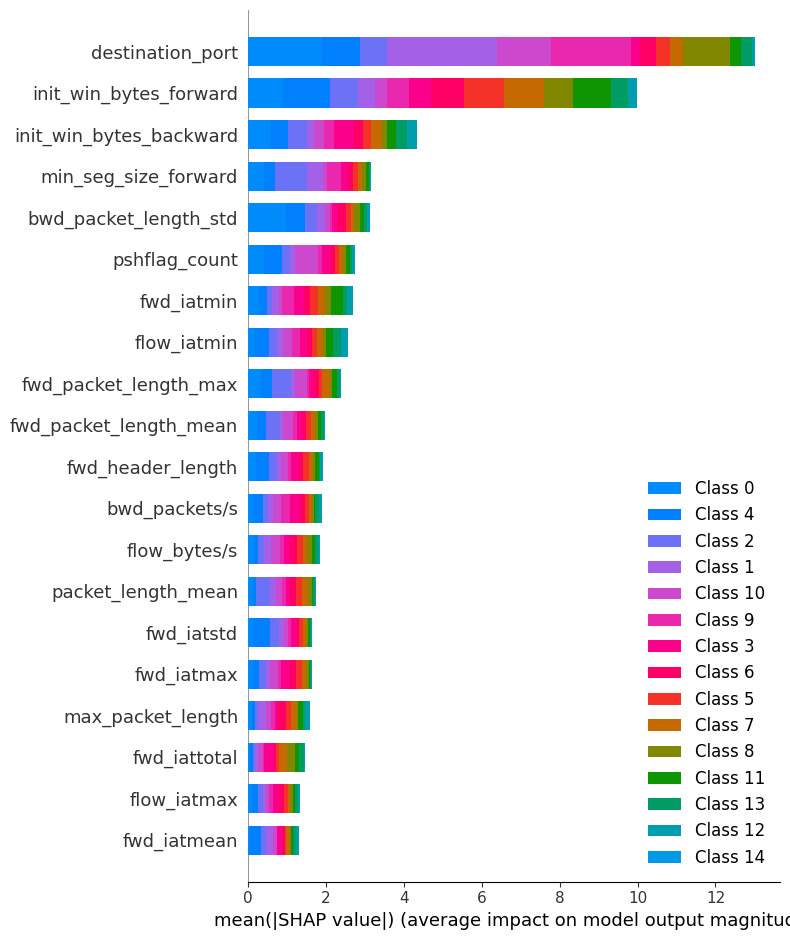

In [64]:
shap.summary_plot(shap_values, X_test)

По графику можно сделать такие выводы:

- Разные признаки влияют на классификацию разных классов
- Есть часть признаков, которые не оказывают влияния на модель
- Можно выделить 5 наиболее важных признаков, оказывающих наибольшее влияние:
    - `destination_port`
    - `init_win_bytes_forward`
    - `init_win_bytes_backward`
    - `fwd_packet_length_max`
    - `psh_flag_count`
- Хотя эти признаки и вносят больший вклад, остальные не менее важны. Если присмотреться, то некоторый незначительный признак значительно влияет на обнаружение конкретного класса угрозы. Удаление каких-либо признаков, даже, казалось бы, бесполезных признаков с нулями, не привело к существенному улучшению метрики.

# 6. Сохрание модели для создания REST API сервиса с использованием Flask и Docker

Для разработки REST API сервиса, потребуется выгрузить модель в отдельный файл.


In [66]:
# Сохраняем модель
model_full_cb.save_model('final_model.cbm')

Создала REST API сервис, который позволяет выполнять предсказания с использованием лучшей модели. В этом сервисе я использовала Python, библиотеку Flask и Docker. Процесс создания сервиса включал следующие шаги:

1) Модель машинного обучения

2) `main.py`: В файле main.py я загрузила обученную модель и создала функцию, которая принимает входные данные и возвращает предсказания, используя Flask.

3) `Docker`: Для упрощения развертывания и управления приложением я создала Docker-образ. Docker обеспечивает изолированную среду для приложения, что упрощает его переносимость и масштабируемость.

4) Тестирование: Для проверки работы сервиса я создала файл test_test, который отправляет тестовый запрос к API и оценивает его производительность и правильность ответов.

# 7. Итоговый вывод.

В этом проекте нужно было построить модель многоклассовой классификации с целью автоматизации выявления аномального и злонамеренного трафика. Получили хорошую метрику и разработали REST API сервис с помощью Flask и контейнеров docker.

**Результаты моделей**

Обучили три модели и получили следующие результаты:

|  Learning model       | F1-score | Accuracy | Precision | Recall   |
|-----------------------|----------|----------|-----------|----------|
| CatBoostClassifier    | 0.872334 | 0.997505 | 0.952216  | 0.851805 |
| LogisticRegression    | 0.657701 | 0.963927 | 0.738378  | 0.652311 |
| RandomForestClassifier| 0.782804 | 0.992274 | 0.907036  | 0.766645 |


На основании этих результатов выбрали и протестировали лучшую модель градиентный бустинг в реализации CatBoostClassifier. 
На тесте получтли следующие результаты:

- F1-macro: 0.9114
- Accuracy: 0.9973
- Precision: 0.9447
- Recall: 0.9002

- Метрика на тренировочных данных больше, чем на тестовой, есть небольшое переобучение. Однако так получилось добиться максимальной метрики на тестовых данных.

- Параметры модели:
params = {'random_seed': 42,
         'learning_rate': 0.01,
         'iterations': 4991,
         'loss_function' : 'MultiClass',
         'eval_metric': 'Accuracy',
         'custom_metric': ['Accuracy','F1', 'Precision', 'Recall'],
         'save_snapshot': False
         }
    

**Выбор признаков**

При обучении модели попробовали удалить 6 признаков, все значения которых составляют нули, однако, при анализе полученных метрик было принято решение вернуться к первоначальному набору признаков и ничего не отсекать. 


**REST API**

Cоздан REST API сервис, который позволяет выполнять предсказания с использованием лучшей модели. В этом сервисе использовали Python, библиотеку Flask и Docker.

**Трудности**

В процессе работы столкнулась с трудностями:

В данных изначально сильный дисбаланс. По этой причине не удалось достичь высоких значений по 2-ум классам: `Web Attack � Brute Force` и `Web Attack � XSS` - в этих классах слишком мало записей. Возможно, следовало применить увеличение выборки или балансировку для этих классов. Однако, есть веросятность, что на этих данных и невозможно достичь высоких значений метрики.

**Итого**

В итоге, проект позволяет автоматизировать процесс выявления злонамеренного трафика, что является важным шагом для обеспечения безопасности сети и обеспечения качественного функционирования веб-сервисов.